<h1>Analysis and visualization of King County Animal shelter data using python</h1>

<h2>Lesson Objectives</h2>

At the end of this exercise, students will be able to:
<ul>
<li>Download and import a dataset from the internet into python for analysis.</li>
<li>Create histograms comparing multiple subgroups in the data.</li>
<li>Plot counts of categorical variables based on subgroups of interest.</li>
<li>Develop a map using geographical data.</li>
</ul>

<h2>Notebook Setup</h2>

Jupyter is essentially just an advanced word processor. In this way, you can think of a notebook document as being somewhat comparable to a script file, except that it is multimedia. 

A code cell contains code to be executed and displays its output below.

Let's test it out with a classic example. 
Type "print('Hello World!')" into the cell below and click the Notebook Run Button (the triangle) in the toolbar above or press Ctrl + Enter.

The code cell below loads the packages we will need to run the rest of the code.

In [1]:
#Sets up all required packages to use Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format='svg'
from IPython.display import display,HTML
import pandas as pd
import seaborn as sns
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context(context="notebook",font_scale=1)

<h2>Dataset</h2>

This Notebook is based on the King County, Washington "Lost, found, adoptable pets" dataset from animal shelter data. <br>
The [dataset](https://data.kingcounty.gov/Licenses-Permits-and-Records/Lost-found-adoptable-pets/yaai-7frk), provided by
Regional Animal Services, is available from the [King County Open Data portal](https://data.kingcounty.gov/).

The CSV contains a row (observation) for each animal. 

In [2]:
#These commands can help us change the directory we download data to, if necessary.
#import os
#os.chdir('../Documents/JupyterLab')
#print(os.getcwd())

#These commands tell Python to request the data from a url and save it to a file
import requests
response = requests.get('https://data.kingcounty.gov/api/views/yaai-7frk/rows.csv?accessType=DOWNLOAD')
filename = "Lost__found__adoptable_pets.csv"
with open(filename, "wb") as f:
    f.write(response.content)  

#This command tells Pandas to place the data into a dataframe:
d = pd.read_csv('Lost__found__adoptable_pets.csv')

Let's have a look at the first 5 animals.

In [3]:
d.head(5)[[c for c in d.columns if "Link" not in c and "Memo" not in c and "Image" not in c and "image_alt_text" not in c]] 
             # Ignore columns with "link", "Memo", "Image" in the name (they are long)

,impound_no,Animal_ID,Data_Source,Record_Type,Current_Location,Animal_Name,animal_type,Age,Animal_Gender,Animal_Breed,...,Date,Date_Type,Obfuscated_Address,City,State,Zip,jurisdiction,obfuscated_latitude,obfuscated_longitude,Temperament
0,K18-114518,A577420,Regional Animal Services of King County,LOST,LOST,Bacardi,Cat,NaN,Female,Maine Coon,...,12/25/2018 12:00:00 AM,Date Lost,EAST MERCER AND SE 39TH ST,NaN,NaN,NaN,JURISDICTION,NaN,NaN,NaN
1,K18-114509,A577413,Regional Animal Services of King County,LOST,LOST,Bolderdash,Dog,NaN,Male,American Pit Bull Terrier,...,12/24/2018 12:00:00 AM,Date Lost,24400 TERRACE PL,BLACK DIAMOND,WA,98010.0,BLACK DIAMOND,NaN,NaN,NaN
2,K18-114417,A577089,Regional Animal Services of King County,LOST,LOST,Smooky,Cat,NaN,Female,Domestic Shorthair,...,12/19/2018 12:00:00 AM,Date Lost,140TH AND 108TH AVE NE,NaN,NaN,NaN,JURISDICTION,NaN,NaN,NaN
3,K17-104325,A533907,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Hera,Cat,11 YEARS -1 MONTHS,Spayed Female,Domestic Shorthair,...,10/28/2017 12:00:00 AM,Received on,21615 64TH AVE S,KENT,WA,98032.0,SEATTLE,47.407788,-122.255197,NaN
4,K18-114546,A577482,Regional Animal Services of King County,LOST,LOST,Weeble,Cat,NaN,Female,American Shorthair,...,12/26/2018 12:00:00 AM,Date Lost,25200 106TH AVE SE,KENT,WA,98030.0,KENT,NaN,NaN,NaN


Let's take a look at what types of animals were turned in or found.

In [4]:
#Take a look at the data and create dataframes (subsets) for each type of animal
dog=d[d["animal_type"]=="Dog"] # dogs
cat=d[d["animal_type"]=="Cat"] # cats
rabbit=d[d["animal_type"]=="Rabbit Sh"] # rabbit
bird=d[d["animal_type"]=="Bird"] # bird

print("{} dogs ({:.1%}), {} cats ({:.1%}), {} rabbits ({:.1%}), {} birds ({:.1%})".format(
    len(dog),len(dog)/len(d),
    len(cat),len(cat)/len(d),
    len(rabbit),len(rabbit)/len(d),
    len(bird),len(bird)/len(d)))
print(type(str(d["Age"][1])))

85 dogs (40.7%), 102 cats (48.8%), 3 rabbits (1.4%), 1 birds (0.5%)
<class 'str'>


<h2>Age distribution</h2>

<h3>Data cleaning</h3>

Since the age is entered in text format, first we need to convert it to months.

In [5]:
#First, extract year, month, and week from string (text) column data
d["years"] = d['Age'].str.extract('(?P<years>\d*)\s*YEAR')
d["months"] = d['Age'].str.extract('(?P<months>\d*)\s*MONTH')
d["weeks"] = d['Age'].str.extract('(?P<weeks>\d*)\s*WEEK')

#Now, convert these new variables to integers
d["years"] = pd.to_numeric(d["years"])
d["months"] = pd.to_numeric(d["months"])
d["weeks"] = pd.to_numeric(d["weeks"])

In [6]:
#Convert age in months to age in fractional years.
#Add together years, months, and weeks, replacing missing values with 0 for now
d["Age_years"] = d["years"].fillna(0) + ((d["months"].fillna(0))/12.0) + ((d["weeks"].fillna(0))/52)

#Now replace 0 values with NaN again
d["Age_years"] = d["Age_years"].replace(0,np.nan)

print(d.head(5)["Age_years"])

0          NaN
1          NaN
2          NaN
3    11.083333
4          NaN
Name: Age_years, dtype: float64


<h3>Age outliers</h3>

There might be outliers in our data. Let's have a look at their data.

In [7]:
print("Age statistics:\n{}".format(d["Age_years"].describe()))
print()
print("There are {} animals older than 12".format((d["Age_years"]>12).sum()))
print()
print("There are {} animals younger than 1".format((d["Age_years"]<1).sum()))

Age statistics:
count    104.000000
mean       5.408715
std        4.820568
min        0.173077
25%        1.229167
50%        3.833333
75%        9.333333
max       18.166667
Name: Age_years, dtype: float64

There are 15 animals older than 12

There are 21 animals younger than 1


Apparently we have 15 animals older than 12, and 22 younger than 1. 
The maximum age is 18. Let's take a look at the very old animals.

In [8]:
d[d["Age_years"]>15]  [[c for c in d.columns if "Link" not in c and "Memo" not in c and "Image" not in c and "image_alt_text" not in c]]

,impound_no,Animal_ID,Data_Source,Record_Type,Current_Location,Animal_Name,animal_type,Age,Animal_Gender,Animal_Breed,...,State,Zip,jurisdiction,obfuscated_latitude,obfuscated_longitude,Temperament,years,months,weeks,Age_years
57,K17-105331,A547918,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Babette,Cat,18 YEARS 1 MONTH,Spayed Female,Domestic Shorthair,...,WA,98032.0,KING COUNTY,47.407788,-122.255197,BLUE,18.0,1.0,NaN,18.083333
64,K18-113628,A574398,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Charlie,Cat,18 YEARS 2 MONTHS,Neutered Male,Domestic Longhair,...,WA,98032.0,KING COUNTY,47.407788,-122.255197,BLUE,18.0,2.0,NaN,18.166667
79,K13-066766,A407026,Regional Animal Services of King County,ADOPTABLE,In RASKC Foster Home,Kiki,Cat,16 YEARS,Spayed Female,Domestic Shorthair,...,WA,98032.0,FEDERAL WAY,47.407788,-122.255197,NaN,16.0,NaN,NaN,16.000000


Let's take a look at where our dataset stands now.

In [9]:
#Now that we have added information about the animals' ages, we will want to redefine our dataframes for each type of animal:
dog=d[d["animal_type"]=="Dog"] # dogs
cat=d[d["animal_type"]=="Cat"] # cats
rabbit=d[d["animal_type"]=="Rabbit Sh"] # rabbit
bird=d[d["animal_type"]=="Bird"] # bird

print("{} dogs ({:.1%}), {} cats ({:.1%}), {} rabbits ({:.1%}), {} birds ({:.1%})".format(
    len(dog),len(dog)/len(d),
    len(cat),len(cat)/len(d),
    len(rabbit),len(rabbit)/len(d),
    len(bird),len(bird)/len(d)))
print(type(str(d["Age"][1])))

print()
print("Age statistics:\n{}".format(d["Age_years"].describe()))

85 dogs (40.7%), 102 cats (48.8%), 3 rabbits (1.4%), 1 birds (0.5%)
<class 'str'>

Age statistics:
count    104.000000
mean       5.408715
std        4.820568
min        0.173077
25%        1.229167
50%        3.833333
75%        9.333333
max       18.166667
Name: Age_years, dtype: float64


We will use this information to help us decide on a good range for our histograms and other visualizations below.

<h3>Create age histograms for dogs and cats</h3>

A histogram is a plot that lets you discover, and show, the underlying frequency distribution (shape) of a set of continuous data.

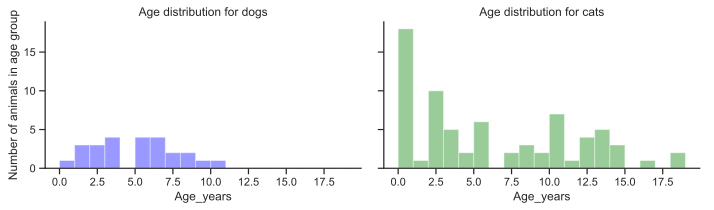

In [10]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3),sharey=True,sharex=True)
sns.distplot(dog["Age_years"].dropna(), ax=ax1,
             bins=range(0,20), 
             kde=False,
             color="blue")
ax1.set_title("Age distribution for dogs")
sns.distplot(cat["Age_years"].dropna(), ax=ax2,
             bins=range(0,20), 
             kde=False,
             color="green")
ax2.set_title("Age distribution for cats")
ax1.set_ylabel("Number of animals in age group")
for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

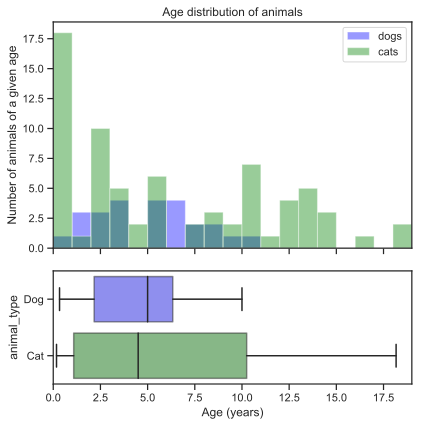

In [11]:
fig,(ax,ax2) = plt.subplots(ncols=1,nrows=2,sharex=True,figsize=(6,6),gridspec_kw={'height_ratios':[2,1]})

# Plot histograms of age
bins=range(0,20) 
sns.distplot(dog["Age_years"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="blue",
             label="dogs")
sns.distplot(cat["Age_years"].dropna(), ax=ax,
             bins=bins,
             kde=False,
             color="green",
             label="cats")
ax.legend(loc="upper right")
ax.set_xlabel("")
ax.set_ylabel("Number of animals of a given age")
ax.set_title("Age distribution of animals");

# Make aligned boxplots
sns.boxplot(data=pd.concat([dog, cat]),  #list of data frames we are using for these plots
            y="animal_type",
            x="Age_years",
            orient="h",
            ax=ax2,
            palette={"Dog":"blue","Cat":"green"})
plt.setp(ax2.artists, alpha=.5)
ax2.set_xlim([min(bins),max(bins)])
ax2.set_xlabel("Age (years)")

#sns.despine(ax=ax)
fig.tight_layout()

<h3>Extension</h3>

How might you extend the above histogram and box plot to include rabbits? We have already created the dataframe for the rabbit's ages (rabbit). Can you add an extra plot to the above to plot the rabbits' ages as well?

<h2>Temperaments of Dogs and Cats</h2>

The [King County Regional Animal Services classifies animals into 3 categories](https://www.kingcounty.gov/depts/regional-animal-services/adopt-a-pet/adoptable-animals.aspx) based on how handlers perceive their temperaments:  <br>

<ul>
<li>"Bashful Blue: Animals in the blue category are gentle and loving, but they may be nervous in new situations. They might need some time to come out of their shell, but once they do they will be a devoted part of the family!" </li>
<li>"Rambunctious Red: Animals in the red category are spirited, independent-thinkers. They may be particular about who or what they like or have quirks that are best suited for seasoned handlers. Investing in them will reward you with a cherished friend!"</li>
<li>"Easy-going Green: Animals in the green category are adaptable and carefree. They are wonderful companions who love to go with the flow!" </li>
</ul>
    
We're going to plot counts of the prevalence of each temperament among the animals, so we can get a better sense of how often they occur:

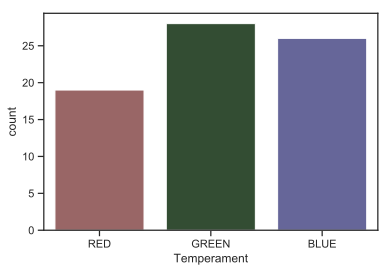

In [12]:
sns.countplot(x="Temperament", 
              data=pd.concat([dog, cat]), 
              orient="h", 
              palette={"GREEN":"green", "BLUE":"blue", "RED":"red"}, 
              saturation=0.2, 
            )

<h3>Extension: Analyzing Temperament by Animal Type</h3>

We might also be interested in looking at how the temperament evaluation varies between dogs and cats, or between whether an animal was lost or found (Record_Type), or based on where the animal is currently housed (Current_Location). Try nesting a variable of your interest within the Temparament analysis to find out more about a question you are interested in.

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,3),sharey=True,sharex=True)
sns.countplot(x="Temperament", 
              data=dog, 

              ax=ax1,
            )
sns.countplot(x="Temperament", 
              data=    ,
              
              
              
              
              
            )

fig.tight_layout()

<h2>Mapping Lost and Found Animals</h2>

Many of the animals include recorded latitudes and longitudes (obfuscated in the public release data) about where they were found. We can use these data to create a map.

In [ ]:
# First we need to import the libraries and packages we will use to create the maps
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import Point
import contextily as ctx  

In [ ]:
#Replace 0 values with NaN, since the (latitude, longitude = 0,0) cannot be accurate
d["obfuscated_longitude"] = d["obfuscated_longitude"].replace(0,np.nan)
d["obfuscated_latitude"] = d["obfuscated_latitude"].replace(0,np.nan)

#A GeoDataFrame needs a shapely object, so we create a new column Coordinates as a tuple of Longitude and Latitude :
d["Coordinates"] = list(zip(d.obfuscated_longitude, d.obfuscated_latitude))

#Then, we transform tuples to Point :
d["Coordinates"] = d["Coordinates"].apply(Point)

#Now, we can create the GeoDataFrame by setting geometry with the coordinates created previously.
gdf = gpd.GeoDataFrame(d, geometry='Coordinates')

# We can now plot our GeoDataFrame.
gdf.plot(color='red')

#Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to convert our data first
#to the same Coordinate Reference System (CRS) to combine our coordinates and background tiles in the same map
gdf.crs = {'init' :'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

In [ ]:
#Let's also take a look at the Geo Dataframe :
gdf.head(5)[["animal_type","Obfuscated_Address","City","obfuscated_latitude","obfuscated_longitude","Coordinates"]]

In [ ]:
#Add background tiles to plot
import contextily as ctx #small helper function that uses contextily to add a map as background to an existing plot
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
# restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
#ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = gdf.plot(figsize=(10, 10), alpha=1.0, edgecolor='k', color='red')
add_basemap(ax, zoom=10)


More precise [geocoding](http://geopandas.org/geocoding.html) could be done by getting more details on the addresses missing latitude and longitude coordinates using the [Google API](https://developers.google.com/maps/documentation/geocoding/start).

<h2>Acknowledgements</h2>

The [dataset](https://data.kingcounty.gov/Licenses-Permits-and-Records/Lost-found-adoptable-pets/yaai-7frk) is available from the [King County Open Data initiative](https://data.kingcounty.gov/).

This Notebook was developed in part based on the [Jupyter Notebook created by Alessandro Giusti and Dalle Molle](https://nbviewer.jupyter.org/github/lalelale/profiles_analysis/blob/master/profiles.ipynb).

Details about how to use Jupyter notebooks come from this website: [Jupyter Notebook for Beginners: A Tutorial](https://www.dataquest.io/blog/jupyter-notebook-tutorial/).